# Multiclass Classification with Neural Networks

In this blog post, we will build a train a model on single class of the MMORPG-AI dataset. We want to predict the RX motion of the gamepad. This contains images of Gennshin Impact Gameplay. You will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to prepare this dataset so it can be fed to a convolutional neural network.


Run the code below to download the compressed dataset `classes.zip`.

In [7]:
!wget https://raw.githubusercontent.com/ruslanmv/BOT-MMORPG-AI/master/versions/0.01/clean_reduced/classes.zip

--2022-06-12 16:29:51--  https://raw.githubusercontent.com/ruslanmv/BOT-MMORPG-AI/master/versions/0.01/clean_reduced/classes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67727611 (65M) [application/zip]
Saving to: 'classes.zip.1'

     0K .......... .......... .......... .......... ..........  0% 5,18M 12s
    50K .......... .......... .......... .......... ..........  0% 9,54M 10s
   100K .......... .......... .......... .......... ..........  0% 4,05M 12s
   150K .......... .......... .......... .......... ..........  0%  108M 9s
   200K .......... .......... .......... .......... ..........  0% 3,63M 11s
   250K .......... .......... .......... .......... ..........  0%  161M 9s
   300K .......... .......... .......... .......... ..........  0% 12,

You can then unzip the archive using the [zipfile](https://docs.python.org/3/library/zipfile.html) module.

In [8]:
import zipfile

# Unzip the dataset
local_zip = './classes.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./classes`, which in turn each contain `rx_left` ,`rx_zero`, and `rx_right` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a rx_left looks like' and 'this is what a rx_rightght looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as rx_left or  rx_right. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. 

So, for example, you will have a 'training' directory containing a ' rx_left ' directory and a 'rx_right ' one. `ImageDataGenerator` will label the images appropriately for you, reducing a coding step. 

You can now define each of these directories:

In [9]:
import os

# Directory with our training rx_left pictures
train_rx_left_dir = os.path.join('./classes/rx_left/')

# Directory with our training rx_right pictures
train_rx_right_dir = os.path.join('./classes/rx_right/')

In [10]:
train_rx_left_dir

'./classes/rx_left/'

Now see what the filenames look like in the `rx_lefts` and `rx_rights` training directories:

In [11]:
train_rx_left_names = os.listdir(train_rx_left_dir)
print(train_rx_left_names[:10])

['clase_rx_left_1022.png', 'clase_rx_left_1024.png', 'clase_rx_left_1040.png', 'clase_rx_left_118.png', 'clase_rx_left_1187.png', 'clase_rx_left_119.png', 'clase_rx_left_123.png', 'clase_rx_left_128.png', 'clase_rx_left_1296.png', 'clase_rx_left_1297.png']


In [12]:
train_rx_right_names = os.listdir(train_rx_right_dir)
print(train_rx_right_names[:10])

['clase_rx_right_0.png', 'clase_rx_right_1025.png', 'clase_rx_right_1026.png', 'clase_rx_right_1027.png', 'clase_rx_right_1028.png', 'clase_rx_right_1029.png', 'clase_rx_right_1030.png', 'clase_rx_right_1031.png', 'clase_rx_right_1032.png', 'clase_rx_right_1039.png']


You can also find out the total number of rx_left and rx_right images in the directories:

In [13]:
print('total training rx_left images:', len(os.listdir(train_rx_left_dir)))
print('total training rx_right images:', len(os.listdir(train_rx_right_dir)))

total training rx_left images: 125
total training rx_right images: 146


Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 rx_left and 8 rx_right pictures. You can rerun the cell to see a fresh batch each time:

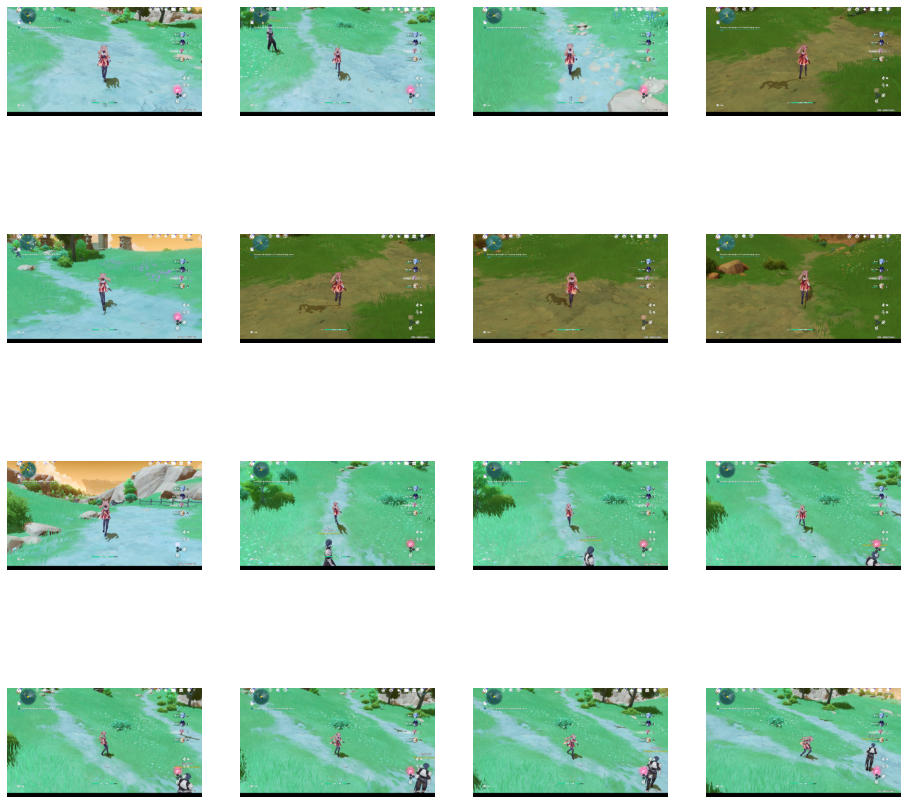

In [15]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_rx_left_pix = [os.path.join(train_rx_left_dir, fname) 
                for fname in train_rx_left_names[pic_index-8:pic_index]]
next_rx_right_pix = [os.path.join(train_rx_right_dir, fname) 
                for fname in train_rx_right_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_rx_left_pix+next_rx_right_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Now you can define the model architecture that you will train.

Step 1 will be to import tensorflow.

In [16]:
#We define the parameters
width= 480
height= 270
ncolors=3

In [17]:
import tensorflow as tf

You then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers. 


Note that if there is a two-class classification problem, i.e. a *binary classification problem*, you will end your network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). 

This makes the output value of your network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

However for multi-class classification problem, i.e. a *non binary classification problem*, you will end your network with a [*softmax* activation](https://wikipedia.org/wiki/Softmax_function). 

The softmax function, also known as softargmax or normalized exponential function, is a generalization of the logistic function to multiple dimensions.




In [18]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image width,height, with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=( width,height, ncolors)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # For binary problem
    
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('rx_lefts') and 1 for the other ('rx_rights')
    #tf.keras.layers.Dense(1, activation='sigmoid')

    # For non binary problem
    
    # Only 3 output neuron for 1 class ('rx_right') the value of 1 
    #                     for 2 class ('rx_lefts') the value of -1
    #                     for 3 class ('rx_zero') the value of zero
    tf.keras.layers.Dense(3, activation='softmax')

])

You can review the network architecture and the output shapes with `model.summary()`.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 268, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 134, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 132, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 66, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 64, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 32, 64)       0

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. 

If we had the vinnary problem the model should have [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) 



However for the multiclass we need 


[`categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) 


We use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation. If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss. There should be # classes floating point values per feature.

We can also use  the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [20]:
from tensorflow.keras.optimizers import RMSprop

# for binary
#model.compile(loss='binary_crossentropy',
#              optimizer=RMSprop(learning_rate=0.001),
#              metrics=['accuracy'])


# for no binary
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 480x270 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.


class_mode: One of "categorical", "binary", "sparse", "input", or None. 

Default: "categorical". Determines the type of label arrays that are returned: 

- "categorical" will be 2D one-hot encoded labels,
- "binary" will be 1D binary labels, 
- "sparse" will be 1D integer labels, 
- "input" will be images identical to input images (mainly used to work with autoencoders). 
- If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). 

Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.


Categorical_crossentropy ( cce ) produces a one-hot array containing the probable match for each category.

Sparse_categorical_crossentropy ( scce ) produces a category index of the most likely matching category.

**Summarizing:**
### Class modes:
- "categorical": 2D output (aka. list of numbers of length N), [0, 0, 1, 0], which is a one-hot encoding (only one number is 1/ "hot") representing the donkey. This is for mutually exclusive labels. A dog cannot be a cat, a human is not a dog.

- "binary": 1D output (aka. 1 number), which is either 0, 1, 2, 3 ... N. It is called this because it is binary if there are only two classes (IMHO this is a bad reason), source. I suggest using "binary" just for single label classification, because it documents-in-code, your intention.

- "sparse": After digging in the code, this is the same as "binary". The logic is done with elif self.class_mode in {'binary', 'sparse'}:, and the class_mode is not used after that. I suggest using "sparse" for multilabel classification though, again because it documents-in-code, your intention.

- "input": The label is literally the image again. So the label for an image of the dog, is the same dog picture array. If I knew more about autoencoders I might have been able to explain further.

- None: No labels, therefore not useful for training, but for inference/ prediction

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './classes/',  # This is the source directory for training images
        target_size=(480, 270),  # All images will be resized to 480x270
        batch_size=128,

        # Since we use binary_crossentropy loss, we need binary labels
        #class_mode='binary'
        
        # Since we use categorical_crossentropy
        class_mode='categorical'
        
        )


Found 326 images belonging to 3 classes.


### Training

You can start training for 50 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 

In [22]:
history = model.fit(
      train_generator,
      steps_per_epoch=2,  
      epochs=50,
      verbose=1)

Epoch 1/50
2/2 [==============================] - 12s 2s/step - loss: 1.1167 - accuracy: 0.5202
Epoch 2/50
2/2 [==============================] - 1s 851ms/step - loss: 1.0330 - accuracy: 0.4394
Epoch 3/50
2/2 [==============================] - 1s 333ms/step - loss: 1.0235 - accuracy: 0.4848
Epoch 4/50
2/2 [==============================] - 2s 764ms/step - loss: 1.0092 - accuracy: 0.4805
Epoch 5/50
2/2 [==============================] - 2s 787ms/step - loss: 1.0004 - accuracy: 0.4805
Epoch 6/50
2/2 [==============================] - 1s 312ms/step - loss: 0.9688 - accuracy: 0.5808
Epoch 7/50
2/2 [==============================] - 1s 324ms/step - loss: 1.0026 - accuracy: 0.5404
Epoch 8/50
2/2 [==============================] - 2s 734ms/step - loss: 0.9623 - accuracy: 0.4961
Epoch 9/50
2/2 [==============================] - 2s 732ms/step - loss: 0.9717 - accuracy: 0.5312
Epoch 10/50
2/2 [==============================] - 1s 828ms/step - loss: 0.9408 - accuracy: 0.5000
Epoch 11/50
2/2 [====

In [23]:
MODEL_NAME ='MMORPG-AI'

In [24]:
print('SAVING MODEL!')
model.save(MODEL_NAME)

SAVING MODEL!


INFO:tensorflow:Assets written to: MMORPG-AI\assets


INFO:tensorflow:Assets written to: MMORPG-AI\assets


## Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a rx_left or a rx_right.

In [164]:
import numpy as np
from keras.preprocessing import image

### We load the image to test

In [165]:
from ipywidgets import FileUpload
from IPython.display import display
uploaded = FileUpload(accept='.png', multiple=False)
display(uploaded)

FileUpload(value={}, accept='.png', description='Upload')

In [105]:
#uploaded.keys

In [140]:
uploaded.metadata

[{'name': 'right.png',
  'type': 'image/png',
  'size': 3982205,
  'lastModified': 1655047541771}]

In [141]:
try:
  os.mkdir('uploaded')
except:
  print("It was created before")

It was created before


### We predict

right.png
1/1 [==============================] - 0s 20ms/step
[6.7953512e-02 9.3204540e-01 1.1590103e-06]
1
Belong to Second Class - rx right


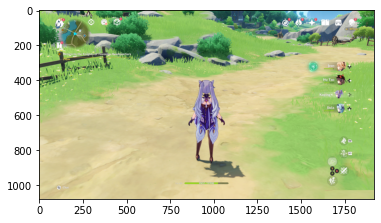

In [142]:
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, load_img

# Loading the uploaded image
with open('./uploaded/image.png', 'wb') as output_file: 
    for uploaded_filename in uploaded.value:
        print(uploaded_filename)
        content = uploaded.value[uploaded_filename]['content']
        output_file.write(content) 


# predicting images
path = './uploaded/image.png'
img = load_img(path, target_size=(480, 270))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])

number_list=list(classes[0])
max_value = max(number_list) 
max_index = number_list.index(max_value)
print(max_index)

if max_index == 0 :
 print("Belong to First Class - rx left")   

if max_index == 1 :
 print("Belong to Second Class - rx right")

if max_index == 2 :
 print("Belong to Third Class - rx zero")

img_test = mpimg.imread(path )
plt.imshow(img_test)

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [149]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

In [150]:
# Prepare a random input image from the training set.
rx_left_img_files = [os.path.join(train_rx_left_dir, f) for f in train_rx_left_names]

In [151]:
rx_right_img_files = [os.path.join(train_rx_right_dir, f) for f in train_rx_right_names]
img_path = random.choice(rx_left_img_files + rx_right_img_files)

In [152]:
img_path

'./classes/rx_right/clase_rx_right_1204.png'

In [153]:
width,height, ncolors

(480, 270, 3)

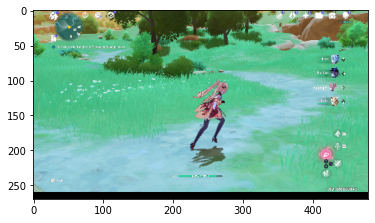

In [154]:
img_test = mpimg.imread(img_path)
plt.imshow(img_test)

In [155]:
img = load_img(img_path, target_size=(width,height))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (width,height, ncolors)

In [156]:
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, width,height, 3)

# Scale by 1/255
x /= 255

In [157]:
# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

1/1 [==============================] - 0s 98ms/step


In [158]:
# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

In [159]:
# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size1, size2, n_features)
    size1 = feature_map.shape[1]
    size2 = feature_map.shape[2]
    print(size1,size2)

239 134
237 132
118 66
116 64
58 32
56 30
28 15
26 13
13 6


C:\Users\rusla\.conda\envs\keras\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


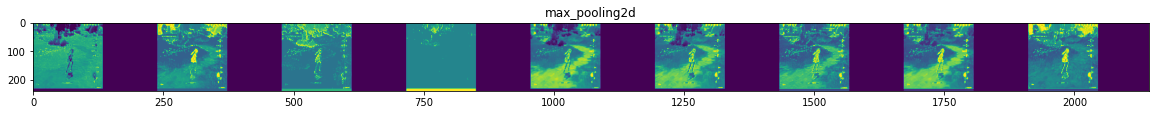

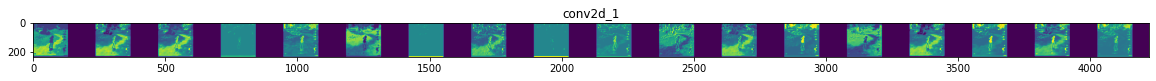

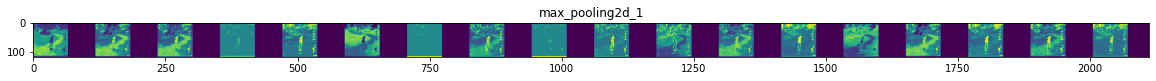

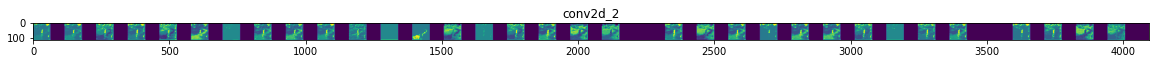

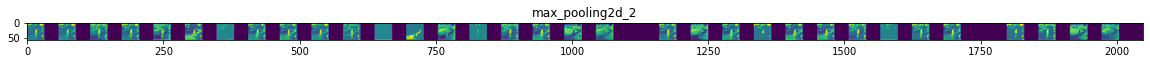

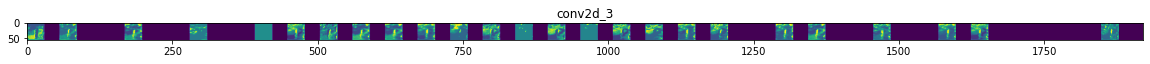

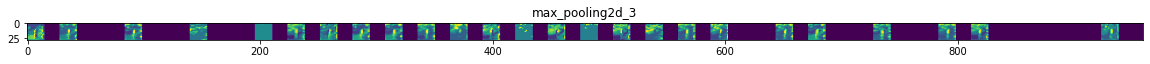

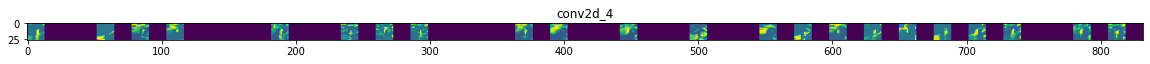

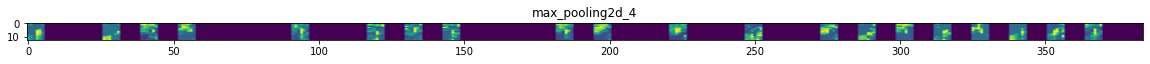

In [160]:
# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    #size = feature_map.shape[1]
    
    # The feature map has shape (1, size1, size2, n_features)
    size1 = feature_map.shape[1]
    size2 = feature_map.shape[2]

    # Tile the images in this matrix
    display_grid = np.zeros((size1, size2 * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
     # print(x)
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      inf=i*size1
      sup=(i*size1 + size2)

      inf_trucco=x.shape[0]
      sup_trucco=x.shape[1]
      check=display_grid[:,inf:sup].shape
      check_y=check[1]
    
      # Tile each filter into this big horizontal grid
      #display_grid[:, i * size : (i + 1) * size] = x
      if sup_trucco == check_y :
          display_grid[:, inf : sup] = x

    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid. 

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

## Congratulations

We have learned how to visualize, train and create a Neural Network model with MMORPG-AI